In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from transformers import BertTokenizer
import os
import re
import tqdm

# Set random seed
SEED = 42
np.random.seed(SEED)


e:\VS code project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# "Test_Cro_Atten_{prop.lower()}_pred_seed_avgweights.csv"数据用来进行可视化每个属性的cls权重

In [2]:
# Define constants
PROPERTY_LIST = ["Concreteness", "Sentiment", "Length", "Numeric", "Suspense", "Pronoun"]
NUM_TEST_IDS = 10  
OUTPUT_DIR = "attention_plots"
MAX_LENGTH = 128  
script_dir = os.getcwd()
print(script_dir)

df_dict = {}
for prop in PROPERTY_LIST:
    data_path = os.path.join(script_dir, f"{prop}", f"Test_Cro_Atten_{prop.lower()}_pred_seed_avgweights.csv")
    try:
        df = pd.read_csv(data_path, encoding="utf-8", encoding_errors="ignore")
        df_dict[prop] = df
    except FileNotFoundError:
        print(f"Error: File {data_path} not found.")
        continue  # Skip if file not found
    

if not df_dict:
    raise ValueError("No data files found for any property.")

# Sample 10 unique test_ids from one of the DFs (assuming same test_ids across all)
first_prop = next(iter(df_dict))
unique_test_ids = df_dict[first_prop]['test_id'].unique()
sampled_test_ids = unique_test_ids[: NUM_TEST_IDS]
print(f"Sampled test_ids: {sampled_test_ids}")

e:\VS code project\Cross Attention Weights
Sampled test_ids: [ 1 20 21 28 34 35 42 43 48 51]


Processing test_id 1 with 5 titles.
处理后的权重为:  [[[0.00599867 0.00621151 0.00626784 0.0060645  0.00587487 0.00651763
   0.00505   ]]]
正则化处理后的权重为:  [[[0.14285725 0.14288765 0.1428957  0.14286664 0.14283957 0.14293139
   0.14272177]]]
属性的权重为 0.14285713
处理后的权重为:  [[[0.00563326 0.00600731 0.00613497 0.00567754 0.0056592  0.00577967
   0.00564062 0.00569489 0.00699496 0.00527573]]]
正则化处理后的权重为:  [[[0.09997833 0.10001574 0.10002851 0.09998276 0.09998094 0.09999298
   0.09997906 0.0999845  0.10011456 0.09994259]]]
属性的权重为 0.1
处理后的权重为:  [[[0.00536406 0.0057725  0.00596403 0.00588065 0.00598159 0.00723028
   0.00489745]]]
正则化处理后的权重为:  [[[0.14278483 0.14284317 0.14287055 0.14285862 0.14287305 0.14305156
   0.14271823]]]
属性的权重为 0.14285715
处理后的权重为:  [[[0.00536294 0.00612771 0.00612236 0.00623594 0.00623992 0.00616772
   0.00606928 0.0049509 ]]]
正则化处理后的权重为:  [[[0.12493168 0.12502727 0.1250266  0.1250408  0.1250413  0.12503226
   0.12501995 0.12488023]]]
属性的权重为 0.12500001
处理后的权重为:  [[[0.00544696 0.00601

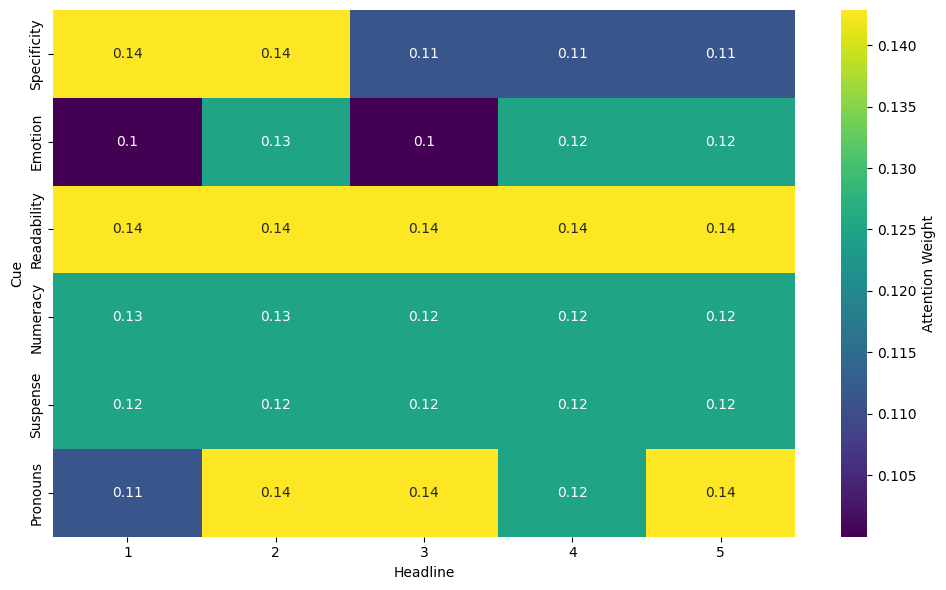

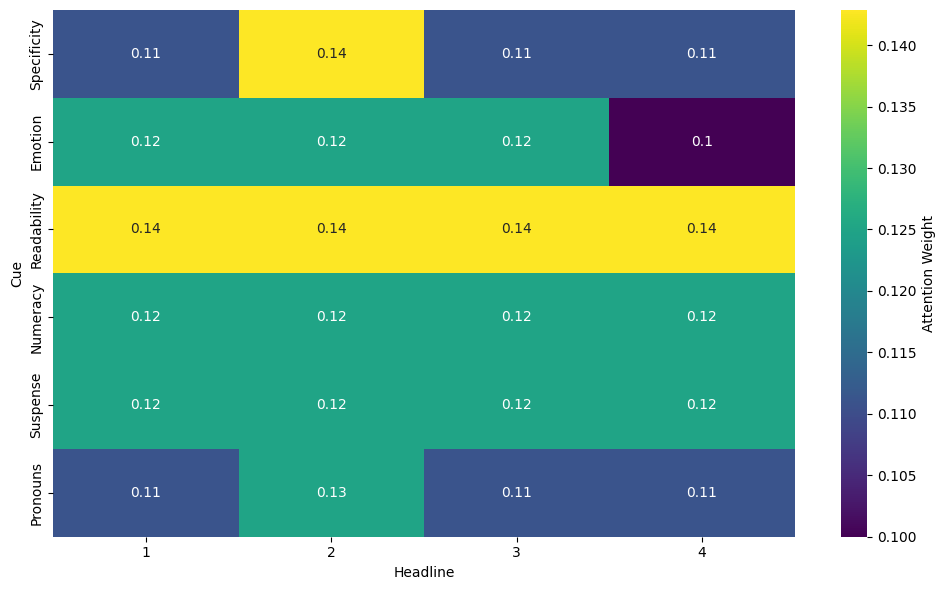

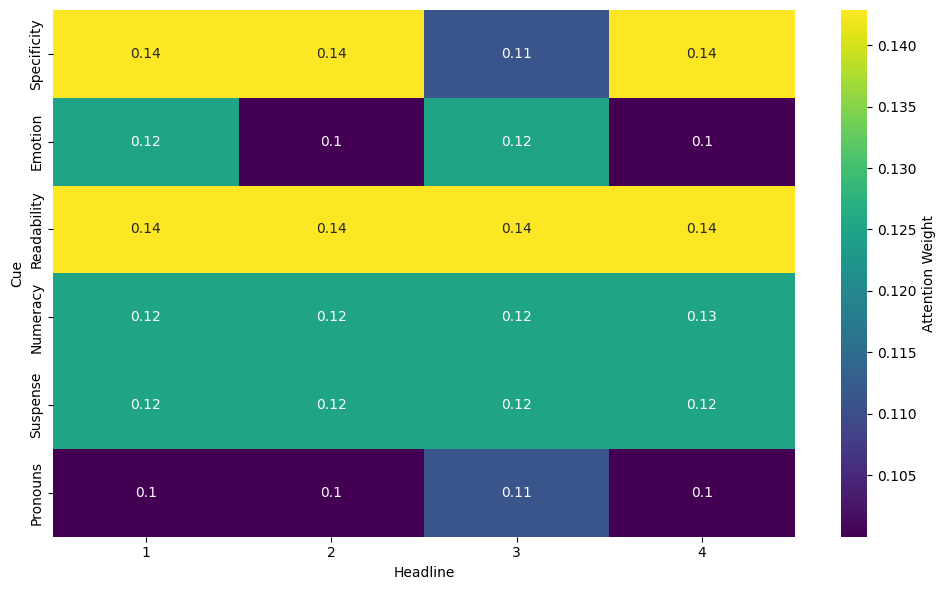

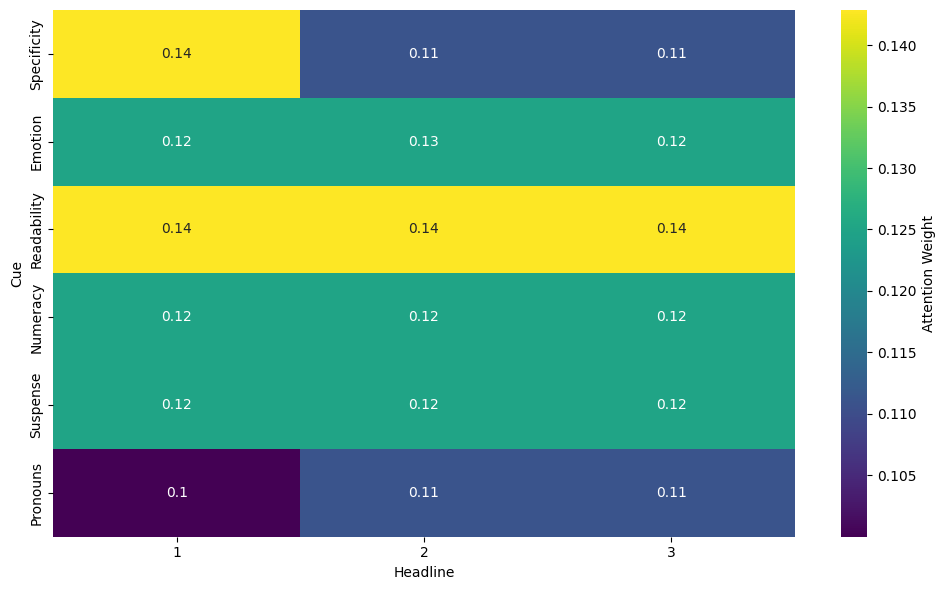

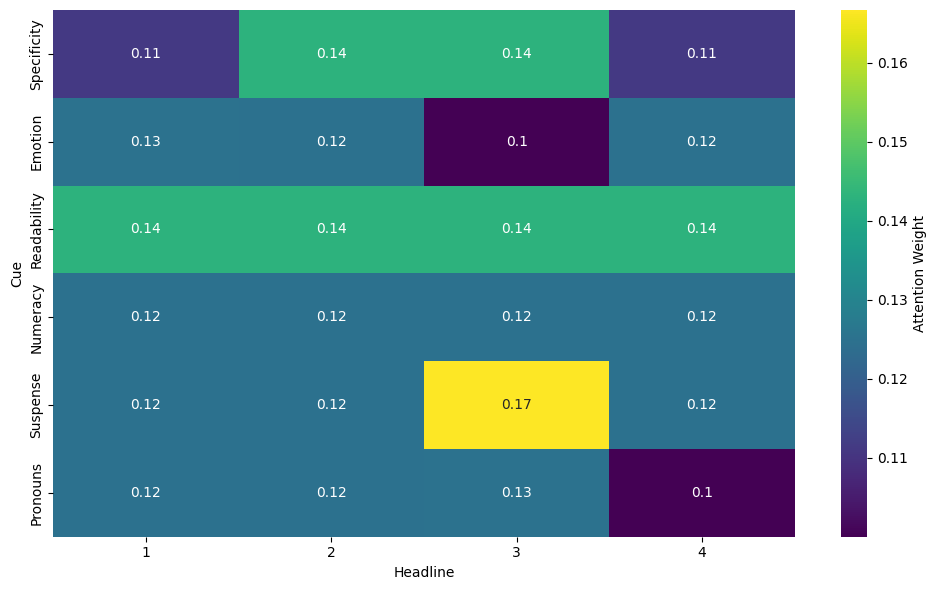

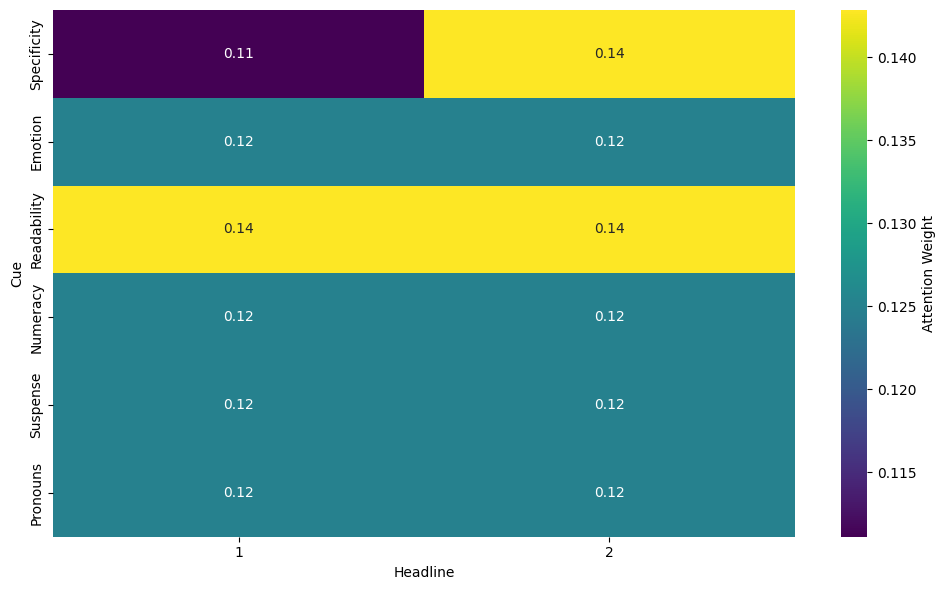

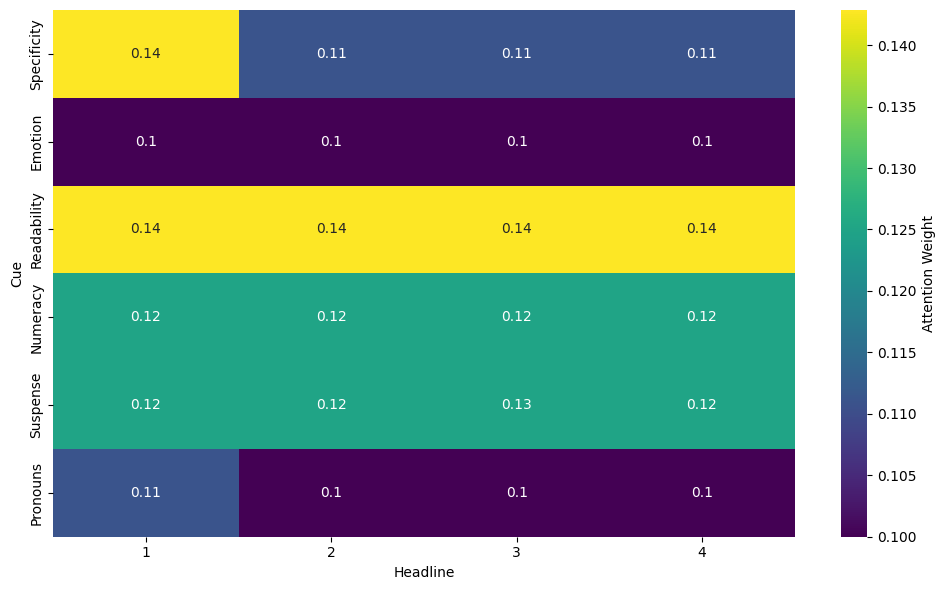

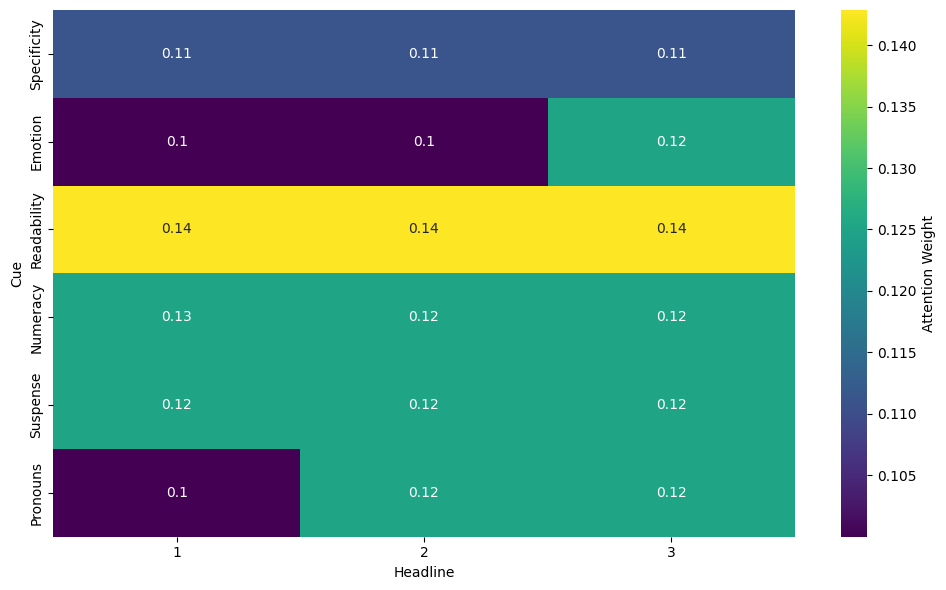

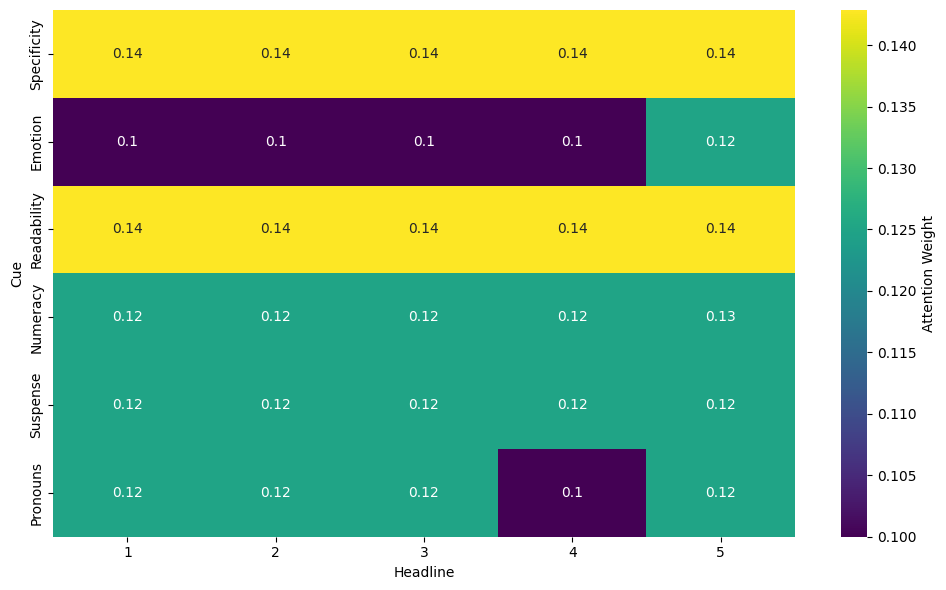

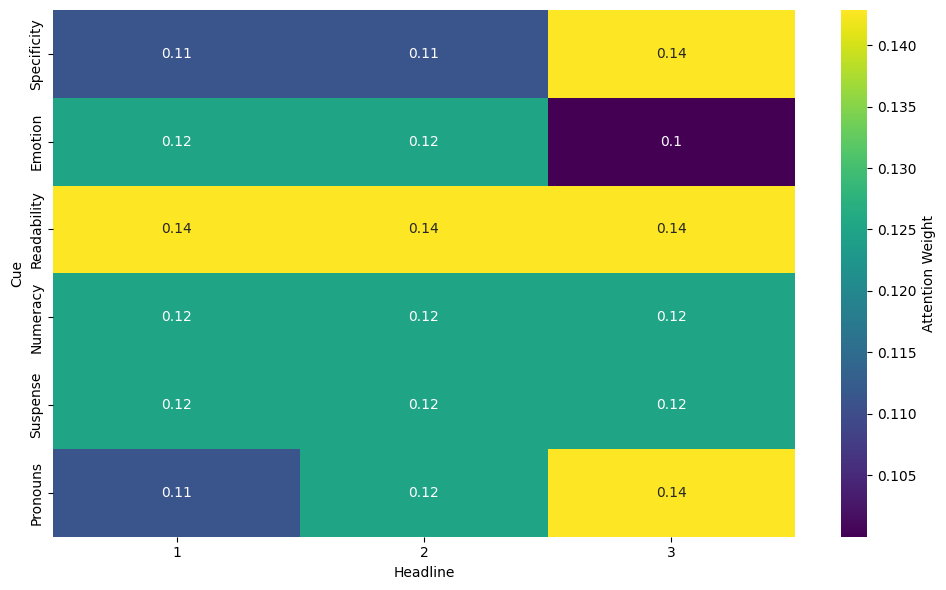

In [3]:
def parse_cls_weight(row):
    cls_attn_weights_str = row['cls_attn_weights']
    # Clean string: remove newlines, tabs, and normalize spaces
    cls_attn_weights_str = cls_attn_weights_str.replace('\n', ' ').replace('\t', ' ').strip()
    # Replace spaces between numbers with commas (match both float and scientific notation)
    cls_attn_weights_str = re.sub(r'(\d*\.\d+(?:e[+-]\d+)?)\s+', r'\1,', cls_attn_weights_str)
    ## (\d* 表示匹配整数部分    （?:e[+-]\d+?) 表示匹配科学计数法，e-0305
    ##  \.  表示匹配小数点       \s+ 表示匹配数后的空白字符串        
    ##  \d+ 表示匹配小数部分)     r'\1,'表示将匹配的字符串保留，空白变为，
    ## 注意，匹配的意思就是找到符合模式的子字符串。

    cls_attn_weights_str = re.sub(r'(\d+\.\d+e[+-])(\d)\b', r'\1\02', cls_attn_weights_str)
    # Remove extra commas and ensure proper nesting
    cls_attn_weights_str = re.sub(r',+', ',', cls_attn_weights_str.strip('[]'))
    cls_attn_weights_str = f"[[[{cls_attn_weights_str}]]]"
    
    try:
        cls_attn_weights_list = ast.literal_eval(cls_attn_weights_str)
        cls_attn_weights = np.array(cls_attn_weights_list, dtype=np.float32)  # [1, 1, n]
        print("处理后的权重为: ",cls_attn_weights)
        cls_attn_weights = np.exp(cls_attn_weights) / np.sum(np.exp(cls_attn_weights), axis=-1, keepdims=True)
        print("正则化处理后的权重为: ", cls_attn_weights)
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing cls_attn_weights for row {row.name}: {e}")
        print(f"Problematic string (first 200 chars): {cls_attn_weights_str[:200]}...")
        # Fallback: extract numbers and reshape
        numbers = re.findall(r'-?\d+\.\d+e[+-]\d+', cls_attn_weights_str)
        flat_list = [float(x) for x in numbers]
        n = len(flat_list)
        cls_attn_weights = np.array(flat_list, dtype=np.float32).reshape(1, 1, n)
        
    # 根据使用token的权重进行融合得到使用"句子"的权重
    # cls_weight = cls_attn_weights[0, 0, 0] if cls_attn_weights.shape[2] > 0 else 0.0     ## 仅摘取[cls]token作为代表
    cls_weight = np.mean(cls_attn_weights) if cls_attn_weights.size > 0 else 0.0          ## 取均值作为代表
    print("属性的权重为",cls_weight)
    return cls_weight

os.makedirs(OUTPUT_DIR, exist_ok=True)
# Process each sampled test_id
for test_id in sampled_test_ids:
    # Use Concreteness DF to get the titles for this test_id
    test_df = df_dict["Concreteness"][df_dict["Concreteness"]['test_id'] == test_id].reset_index(drop=True)
    num_titles = len(test_df)
    if num_titles == 0:
        print(f"No titles found for test_id {test_id}. Skipping.")
        continue
    
    print(f"Processing test_id {test_id} with {num_titles} titles.")

    cls_weights_matrix = np.zeros((len(PROPERTY_LIST), num_titles))

    for sample_idx in range(num_titles):
        headline = test_df.iloc[sample_idx]['headline']
        for prop_idx, prop in enumerate(PROPERTY_LIST):
            prop_df = df_dict[prop]
            matching_row = prop_df[(prop_df['test_id'] == test_id) & (prop_df['headline'] == headline)]
            if matching_row.empty:
                print(f"No matching row found for test_id {test_id}, headline '{headline}' in {prop}. Setting cls_weight to 0.0.")
                cls_weight = 0.0
            else:
                row = matching_row.iloc[0]
                cls_weight = parse_cls_weight(row)
            cls_weights_matrix[prop_idx, sample_idx] = cls_weight
    
    ## 对应着定义一个更为标准的名称
    property_map = {
    "Concreteness": "Specificity",
    "Sentiment": "Emotion",
    "Length": "Readability",
    "Numeric": "Numeracy",
    "Suspense": "Suspense",
    "Pronoun": "Pronouns"
    }
    property_list = [property_map[prop] for prop in PROPERTY_LIST]       

    # 创造热图
    plt.figure(figsize=(10, 6) if num_titles < 20 else (20, 6))
    sns.heatmap(
        cls_weights_matrix,
        xticklabels=range(1, num_titles + 1),
        yticklabels=property_list,
        cmap='viridis',
        cbar_kws={'label': 'Attention Weight'},
        annot=True
    )
    # plt.title(f'Attention Weights for test_id {test_id}')
    plt.ylabel("Cue")
    plt.xlabel('Headline')
    plt.tight_layout()

    # Save heatmap
    plot_path = os.path.join(OUTPUT_DIR, f'test_id_{test_id}_cls_heatmap.png')
    plt.savefig(plot_path)
    # plt.close()
    print(f"Saved heatmap for test_id {test_id} to {plot_path}")

In [4]:
# Define constants
PROPERTY_LIST = ["Concreteness", "Sentiment", "Length", "Numeric", "Suspense", "Pronoun"]
NUM_TEST_IDS = 10  
OUTPUT_DIR = "attention_plots"
MAX_LENGTH = 128  
script_dir = os.getcwd()
print(script_dir)

df_dict = {}
for prop in PROPERTY_LIST:

    data_path = os.path.join(script_dir, f"{prop}", f"New_Headline_Cro_Atten_{prop.lower()}_pred_seed_avgweights.csv")
    try:
        df = pd.read_csv(data_path, encoding="utf-8", encoding_errors="ignore")
        df_dict[prop] = df
    except FileNotFoundError:
        print(f"Error: File {data_path} not found.")
        continue  # Skip if file not found
    

if not df_dict:
    raise ValueError("No data files found for any property.")
print(df_dict)
# # Sample 10 unique test_ids from one of the DFs (assuming same test_ids across all)
# first_prop = next(iter(df_dict))
# unique_test_ids = df_dict[first_prop]['test_id'].unique()
# sampled_test_ids = unique_test_ids[: NUM_TEST_IDS]
# print(f"Sampled test_ids: {sampled_test_ids}")

e:\VS code project\Cross Attention Weights
{'Concreteness':                    Sentiment_Label                    Length_Label  test_id  \
0  The headline has a neutral tone  The headline contains 19 words        0   
1  The headline has a neutral tone  The headline contains 10 words        0   
2  The headline has a negtive tone  The headline contains 17 words        0   
3  The headline has a negtive tone  The headline contains 13 words        0   
4  The headline has a neutral tone  The headline contains 11 words        0   

                                            headline   CTR  \
0  darwin nunez joins al hilal: liverpool sell st...  0.02   
1  instead of sanctions, donald trump announces a...  0.02   
2  machine gun kelly said he sometimes feels ligh...  0.02   
3  how flossing a mouse��s teeth could lead to a ...  0.02   
4  kfc parent company: ai is driving ��marketing ...  0.02   

   Concreteness_Score  Numeric_Structure_Score  Suspense_Question_Score  \
0            0.39

Processing test_id 51 with 5 titles.
处理后的权重为:  [[[0.00611232 0.00637687 0.00634503 0.00611763 0.00575026 0.00562984
   0.00599255 0.00647012 0.0051675 ]]]
正则化处理后的权重: [[[0.11112404 0.11115345 0.11114991 0.11112465 0.11108382 0.11107045
   0.11111074 0.11116382 0.1110191 ]]]
属性的权重为 0.11111111
处理后的权重为:  [[[0.00565086 0.00591021 0.0061087  0.00565867 0.00565414 0.00598994
   0.00723234 0.00514377]]]
正则化处理后的权重: [[[0.12496652 0.12499893 0.12502375 0.12496749 0.12496693 0.1250089
   0.12516432 0.12490316]]]
属性的权重为 0.125
处理后的权重为:  [[[0.00541979 0.00583132 0.00605296 0.0059518  0.0060938  0.00711175
   0.00488078]]]
正则化处理后的权重: [[[0.14278767 0.14284645 0.14287812 0.14286365 0.14288393 0.14302947
   0.14271072]]]
属性的权重为 0.14285712
处理后的权重为:  [[[0.00559507 0.00595538 0.00604666 0.00609411 0.00588718 0.00582228
   0.00572857 0.00598947 0.0058857  0.00538062 0.00527169]]]
正则化处理后的权重: [[[0.09089165 0.09092439 0.0909327  0.09093701 0.0909182  0.09091229
   0.09090378 0.0909275  0.09091806 0.09087215 0.0

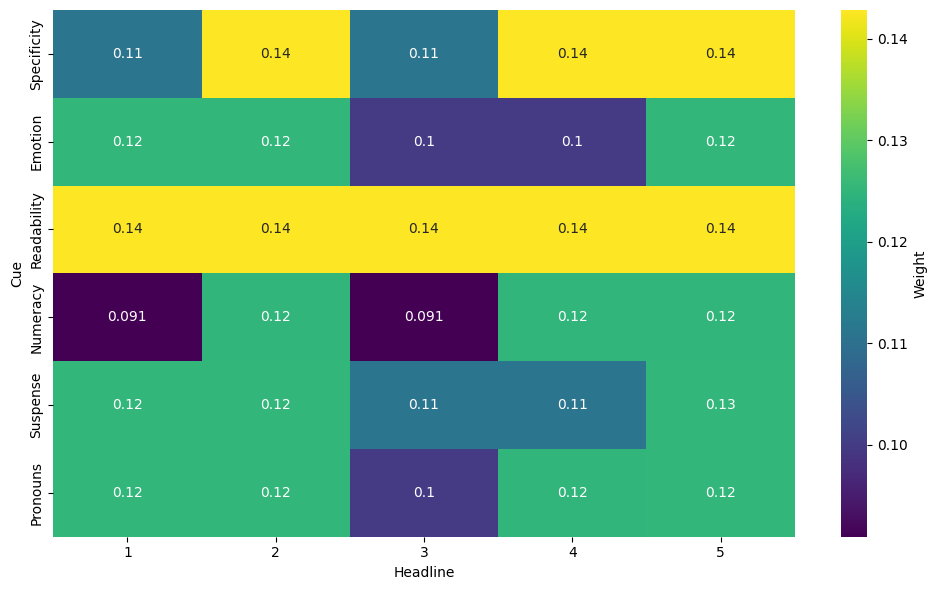

In [5]:
def parse_cls_weight(row):
    cls_attn_weights_str = row['cls_attn_weights']
    # Clean string: remove newlines, tabs, and normalize spaces
    cls_attn_weights_str = cls_attn_weights_str.replace('\n', ' ').replace('\t', ' ').strip()
    # Replace spaces between numbers with commas (match both float and scientific notation)
    cls_attn_weights_str = re.sub(r'(\d*\.\d+(?:e[+-]\d+)?)\s+', r'\1,', cls_attn_weights_str)
    ## (\d* 表示匹配整数部分    （?:e[+-]\d+?) 表示匹配科学计数法，e-0305
    ##  \.  表示匹配小数点       \s+ 表示匹配数后的空白字符串        
    ##  \d+ 表示匹配小数部分)     r'\1,'表示将匹配的字符串保留，空白变为，
    ## 注意，匹配的意思就是找到符合模式的子字符串。

    cls_attn_weights_str = re.sub(r'(\d+\.\d+e[+-])(\d)\b', r'\1\02', cls_attn_weights_str)
    # Remove extra commas and ensure proper nesting
    cls_attn_weights_str = re.sub(r',+', ',', cls_attn_weights_str.strip('[]'))
    cls_attn_weights_str = f"[[[{cls_attn_weights_str}]]]"
    
    try:
        cls_attn_weights_list = ast.literal_eval(cls_attn_weights_str)
        cls_attn_weights = np.array(cls_attn_weights_list, dtype=np.float32)  # [1, 1, n]
        print("处理后的权重为: ",cls_attn_weights)

        cls_attn_weights = np.exp(cls_attn_weights) / np.sum(np.exp(cls_attn_weights), axis=-1, keepdims=True)
        # cls_attn_weights = cls_attn_weights / np.sum(cls_attn_weights, axis=-1, keepdims=True)
        print("正则化处理后的权重:", cls_attn_weights)
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing cls_attn_weights for row {row.name}: {e}")
        print(f"Problematic string (first 200 chars): {cls_attn_weights_str[:200]}...")
        # Fallback: extract numbers and reshape
        numbers = re.findall(r'-?\d+\.\d+e[+-]\d+', cls_attn_weights_str)
        flat_list = [float(x) for x in numbers]
        n = len(flat_list)
        cls_attn_weights = np.array(flat_list, dtype=np.float32).reshape(1, 1, n)
        
    # 根据使用token的权重进行融合得到使用"句子"的权重
    cls_weight = cls_attn_weights[0, 0, 0] if cls_attn_weights.shape[2] > 0 else 0.0     ## 仅摘取[cls]token作为代表
    cls_weight = np.mean(cls_attn_weights) if cls_attn_weights.size > 0 else 0.0          ## 取均值作为代表
    print("属性的权重为",cls_weight)
    return cls_weight


# Process each sampled test_id
test_df = df_dict["Concreteness"].reset_index(drop=True)
num_titles = len(test_df)
if num_titles == 0:
    print(f"No titles found for test_id {test_id}. Skipping.")

    
print(f"Processing test_id {test_id} with {num_titles} titles.")

cls_weights_matrix = np.zeros((len(PROPERTY_LIST), num_titles))

for sample_idx in range(0, num_titles):
    headline = test_df.iloc[sample_idx]['headline']
    for prop_idx, prop in enumerate(PROPERTY_LIST):
        prop_df = df_dict[prop]
        matching_row = prop_df[(prop_df['test_id'] == 0) & (prop_df['headline'] == headline)]
        if matching_row.empty:
            print(f"No matching row found for test_id {test_id}, headline '{headline}' in {prop}. Setting cls_weight to 0.0.")
            cls_weight = 0.0
        else:
            row = matching_row.iloc[0]
            cls_weight = parse_cls_weight(row)
        cls_weights_matrix[prop_idx, sample_idx] = cls_weight
        # print(cls_weights_matrix)



## 对应着定义一个更为标准的名称
property_map = {
    "Concreteness": "Specificity",
    "Sentiment": "Emotion",
    "Length": "Readability",
    "Numeric": "Numeracy",
    "Suspense": "Suspense",
    "Pronoun": "Pronouns"
}
property_list = [property_map[prop] for prop in PROPERTY_LIST]       

# 创造热图
plt.figure(figsize=(10, 6) if num_titles < 20 else (20, 6))
sns.heatmap(
        cls_weights_matrix,

        xticklabels=range(1, num_titles + 1),
        yticklabels=property_list,
        cmap='viridis',
        cbar_kws={'label': 'Weight'},
        annot=True
    )


# plt.title(f'Attention Weights for test_id {test_id}')
plt.ylabel("Cue")
plt.xlabel('Headline')
plt.tight_layout()

# Save heatmap
plot_path = os.path.join(OUTPUT_DIR, f'test_id_{test_id}_cls_heatmap.png')
plt.savefig(plot_path)
    # plt.close()
print(f"Saved heatmap for test_id {test_id} to {plot_path}")


Processing last headline: 'kfc parent company: ai is driving ��marketing revolution, not just evolution��.' at index 4
[0.14285715 0.125      0.14285715 0.12499999 0.12500001 0.125     ]


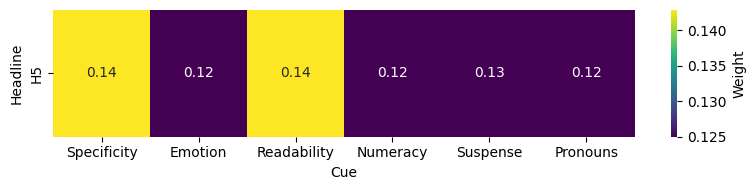

In [6]:
last_idx = num_titles - 1
last_headline = test_df.iloc[last_idx]['headline']
print(f"Processing last headline: '{last_headline}' at index {last_idx}")
cls_weights_vector = cls_weights_matrix[:, last_idx]        ## 提取最后一个标题的权重更新向量
print(cls_weights_vector)
# 对于最后一个标题进行可视化，因为根据上一个可视化结果可以发现最后一个标题是存在显著差异的
plt.figure(figsize=(8, 2) if num_titles < 20 else (20, 6))
sns.heatmap(
        cls_weights_vector.reshape(1, -1),
        xticklabels=property_list,
        yticklabels=["H5"],
        
        cmap='viridis',
        cbar_kws={'label': 'Weight'},
        annot=True
    )

# plt.title(f'Attention Weights for test_id {test_id}')
plt.xlabel("Cue")
plt.ylabel('Headline')
plt.tight_layout()

